<a href="https://colab.research.google.com/github/Kalima83/procesamiento_lenguaje_natural/blob/main/clase_1/ejercicios/Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install numpy scikit-learn

### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [4]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [5]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidfvect = TfidfVectorizer()

In [6]:
# en el atributo `data` accedemos al texto
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [7]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [8]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'Cantidad de documentos: {X_train.shape[0]}')
print(f'Tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [9]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [10]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [11]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [12]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [13]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [14]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [15]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [16]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([4811, 6635, 4253, ..., 9019, 9016, 8748])

In [17]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [18]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [19]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [20]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [21]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [22]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

### Consigna del desafío 1

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.**

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad. (f1-macro // similaridad de coseno)

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**NO cambiar el hiperparámetro ngram_range de los vectorizadores**.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

**Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.


### 1. Vectorizar los datos de entrenamiento

In [25]:
# Usamos fit_transform para aprender el vocabulario y el IDF, y luego transformar los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)

# Vectorizar los datos de test
# Usamos solo transform para aplicar el vocabulario y el IDF aprendidos en el conjunto de entrenamiento
X_test = tfidfvect.transform(newsgroups_test.data)

print("Documentos de entrenamiento vectorizados. Forma de la matriz X_train:")
print(X_train.shape)
print("\nDocumentos de test vectorizados. Forma de la matriz X_test:")
print(X_test.shape)

Documentos de entrenamiento vectorizados. Forma de la matriz X_train:
(11314, 101631)

Documentos de test vectorizados. Forma de la matriz X_test:
(7532, 101631)


####Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Mostrar los 5 documentos más similares de cada uno.

In [27]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Seleccionar 5 índices de documentos al azar del conjunto de entrenamiento
#random_selected_indices = random.sample(range(len(newsgroups_train.data)), 5)

# Se eligen 5 documentos de la primera seleccion random
random_selected_indices = [9685, 2703, 493, 2053, 6285]
print("5 documentos seleccionados al azar:")
print(random_selected_indices)

print("\n================================5 documentos mas similares====================================================")

# Seleccionar los documentos
random_selected_documents = [newsgroups_train.data[i] for i in random_selected_indices]

# Vectorizar los documentos seleccionados al azar utilizando el TfidfVectorizer
X_random_selected = tfidfvect.transform(random_selected_documents)

# Calcular la similaridad coseno entre todos los documentos de entrenamiento
# Tomar los 5 con mayor similaridad
cossim_selected = cosine_similarity(X_random_selected, X_train)


for i, doc_idx in enumerate(random_selected_indices):
    print(f"\n--- Documentos más similares al Documento {doc_idx} ---")
    # Obtener los puntajes de similaridad para el documento seleccionado actual
    current_cossim = cossim_selected[i]

    # Obtener los índices de los documentos ordenados por similaridad de mayor a menor
    most_similar_indices = np.argsort(current_cossim)[::-1][1:6] # [1:6] para obtener los 5 primeros excluyendo el original

    # Imprimir la categoría del documento original
    original_category = newsgroups_train.target_names[newsgroups_train.target[doc_idx]]
    print(f"Categoría del Documento Original: {original_category}")

    # Crear una lista de los datos de los documentos similares
    similar_docs_data = []

    # Recopilar los datos de los 5 documentos más similares
    for similar_doc_idx in most_similar_indices:
        similarity_score = current_cossim[similar_doc_idx]
        similar_doc_category = newsgroups_train.target_names[newsgroups_train.target[similar_doc_idx]]
        similar_docs_data.append({
            "Documento Similar (Índice)": similar_doc_idx,
            "Similaridad Coseno": similarity_score,
            "Categoría del Documento Similar": similar_doc_category
        })

    # Crear un DataFrame de pandas con los datos y mostrarlo
    df_similar_docs = pd.DataFrame(similar_docs_data)
    display(df_similar_docs)

5 documentos seleccionados al azar:
[9685, 2703, 493, 2053, 6285]

================================5 documentos mas similares====================================================

--- Documentos más similares al Documento 9685 ---
Categoría del Documento Original: talk.politics.mideast


,Documento Similar (Índice),Similaridad Coseno,Categoría del Documento Similar
0,3687,0.492743,talk.politics.mideast
1,5332,0.351622,talk.politics.mideast
2,2847,0.326602,talk.politics.mideast
3,10637,0.308731,talk.politics.mideast
4,8754,0.285285,talk.religion.misc



--- Documentos más similares al Documento 2703 ---
Categoría del Documento Original: comp.sys.ibm.pc.hardware


,Documento Similar (Índice),Similaridad Coseno,Categoría del Documento Similar
0,3286,0.131933,soc.religion.christian
1,804,0.125007,comp.sys.ibm.pc.hardware
2,4794,0.124221,comp.os.ms-windows.misc
3,5302,0.121863,comp.os.ms-windows.misc
4,4271,0.116019,talk.politics.misc



--- Documentos más similares al Documento 493 ---
Categoría del Documento Original: comp.windows.x


,Documento Similar (Índice),Similaridad Coseno,Categoría del Documento Similar
0,8911,0.310207,sci.space
1,7584,0.268038,sci.crypt
2,1532,0.213838,rec.motorcycles
3,9521,0.195125,sci.space
4,7289,0.171416,talk.politics.mideast



--- Documentos más similares al Documento 2053 ---
Categoría del Documento Original: talk.religion.misc


,Documento Similar (Índice),Similaridad Coseno,Categoría del Documento Similar
0,1191,0.220677,talk.politics.misc
1,70,0.209764,talk.politics.mideast
2,3746,0.203593,talk.politics.misc
3,5423,0.197183,talk.politics.mideast
4,6894,0.188944,talk.politics.guns



--- Documentos más similares al Documento 6285 ---
Categoría del Documento Original: rec.autos


,Documento Similar (Índice),Similaridad Coseno,Categoría del Documento Similar
0,8677,0.200890,rec.autos
1,7993,0.183283,rec.autos
2,2749,0.179501,rec.autos
3,6224,0.168774,rec.autos
4,7061,0.166660,rec.motorcycles


### 2. Construir un modelo de clasificación por prototipos (tipo zero-shot)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import f1_score

print("==================Clasificación zero-shot basada en similaridad============================")

# Calcular la similaridad coseno entre cada documento de test y todos los documentos de entrenamiento
# X_test: matriz vectorizada de documentos de test
# X_train: matriz vectorizada de documentos de entrenamiento
# El resultado será una matriz donde element (i, j) es la similaridad entre
# el i-ésimo documento de test y el j-ésimo documento de entrenamiento.
# Esto puede tomar un tiempo considerable dependiendo del tamaño de los datasets.
similarity_matrix_test_train = cosine_similarity(X_test, X_train)

print(f"Cálculo de la matriz de similaridad entre test y train. Forma: {similarity_matrix_test_train.shape}")

# Para cada documento de test, encontrar el índice del documento de entrenamiento más similar
most_similar_train_indices = np.argmax(similarity_matrix_test_train, axis=1)

# Las etiquetas predichas para el conjunto de test serán las etiquetas de los documentos de entrenamiento más similares
y_pred_zero_shot = newsgroups_train.target[most_similar_train_indices]

# Evaluar el desempeño utilizando F1-score macro
# y_test contiene las etiquetas reales del conjunto de test
# y_pred_zero_shot contiene las etiquetas predichas por nuestro clasificador zero-shot
f1_macro_zero_shot = f1_score(y_test, y_pred_zero_shot, average='macro')

print(f"\nF1-score macro para el clasificador zero-shot: {f1_macro_zero_shot:.4f}")

==================Clasificación zero-shot basada en similaridad============================
Cálculo de la matriz de similaridad entre test y train. Forma: (7532, 11314)

F1-score macro para el clasificador zero-shot: 0.5050


### 3. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test.

In [38]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

print("===================Evaluando MultinomialNB con variacion del parámetros Alpha =======================")


===================Evaluando MultinomialNB con variacion del parámetros Alpha =======================


Experimentando con diferentes valores de alpha para MultinomialNB:

Resultados F1-score macro para diferentes valores de alpha:
Alpha = 0.0010, F1-score macro = 0.6713
Alpha = 0.0100, F1-score macro = 0.6829
Alpha = 0.1000, F1-score macro = 0.6565
Alpha = 0.2000, F1-score macro = 0.6425
Alpha = 0.3000, F1-score macro = 0.6322
Alpha = 0.4000, F1-score macro = 0.6224
Alpha = 0.5000, F1-score macro = 0.6153
Alpha = 0.6000, F1-score macro = 0.6077
Alpha = 0.7000, F1-score macro = 0.6011
Alpha = 0.8000, F1-score macro = 0.5950
Alpha = 0.9000, F1-score macro = 0.5903
Alpha = 1.0000, F1-score macro = 0.5854
Alpha = 2.0000, F1-score macro = 0.5400
Alpha = 5.0000, F1-score macro = 0.4689
Alpha = 10.0000, F1-score macro = 0.3986


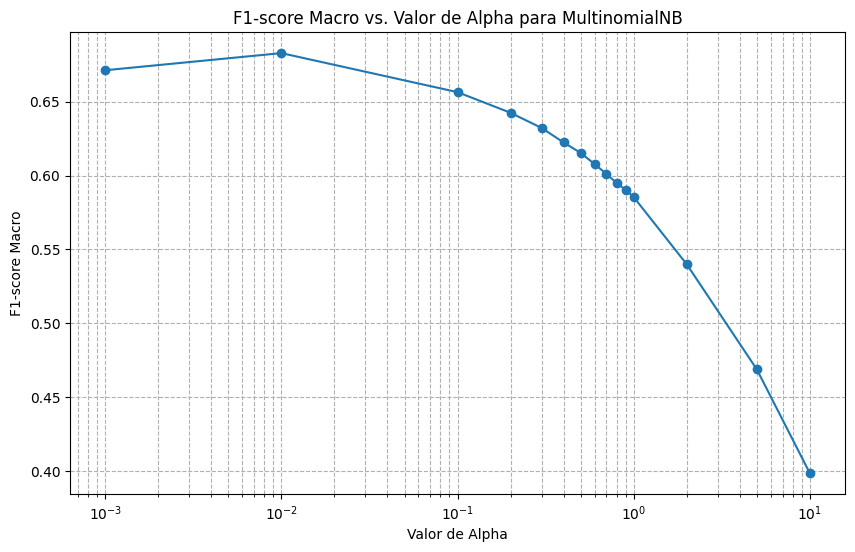

In [39]:
# Valores de alpha
alpha_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 10.0]

# Listas para almacenar los resultados
f1_scores = []

print("Experimentando con diferentes valores de alpha para MultinomialNB:")

for alpha in alpha_values:
    mnb_clf = MultinomialNB(alpha=alpha)

    # Entrenar el modelo
    mnb_clf.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = mnb_clf.predict(X_test)

    # Calcular F1-score macro
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

# Mostrar los resultados
print("\nResultados F1-score macro para diferentes valores de alpha:")
for alpha, f1 in zip(alpha_values, f1_scores):
    print(f"Alpha = {alpha:.4f}, F1-score macro = {f1:.4f}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, f1_scores, marker='o')
plt.xscale('log') # Escala logarítmica para el eje x si los valores de alpha varían mucho
plt.xlabel("Valor de Alpha")
plt.ylabel("F1-score Macro")
plt.title("F1-score Macro vs. Valor de Alpha para MultinomialNB")
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
# Valores de alpha
alpha_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 10.0]

# Listas para almacenar los resultados
f1_scores_cnb = []

print("Experimentando con diferentes valores de alpha para ComplementNB:")

for alpha in alpha_values:
    # Instanciar el modelo Complement Naïve Bayes con el valor de alpha actual
    cnb_clf = ComplementNB(alpha=alpha)

    # Entrenar el modelo
    cnb_clf.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_cnb = cnb_clf.predict(X_test)

    # Calcular F1-score macro
    f1_cnb = f1_score(y_test, y_pred_cnb, average='macro')
    f1_scores_cnb.append(f1_cnb)

# Mostrar los resultados
print("\nResultados F1-score macro para diferentes valores de alpha (ComplementNB):")
for alpha, f1_cnb in zip(alpha_values, f1_scores_cnb):
    print(f"Alpha = {alpha:.4f}, F1-score macro = {f1_cnb:.4f}")

# Opcional: Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, f1_scores_cnb, marker='o', color='orange')
plt.xscale('log') # Usar escala logarítmica para el eje x si los valores de alpha varían mucho
plt.xlabel("Valor de Alpha")
plt.ylabel("F1-score Macro")
plt.title("F1-score Macro vs. Valor de Alpha para ComplementNB")
plt.grid(True, which="both", ls="--")
plt.show()

### 4.


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

print("Transponiendo la matriz documento-término...")
# Transponer la matriz X_train (documento-término) para obtener la matriz término-documento
# La matriz esparsa X_train es de forma (n_documentos, n_terminos).
# Al transponerla, obtenemos una matriz de forma (n_terminos, n_documentos).
X_train_transposed = X_train.T

print(f"Matriz término-documento creada. Forma: {X_train_transposed.shape}")

print("\nCalculando similaridad entre palabras...")
# Ahora, las filas de X_train_transposed representan los vectores de las palabras.
# Calculamos la similaridad coseno entre estas filas para obtener la similaridad entre palabras.
# Esto puede ser computacionalmente intensivo si el vocabulario es muy grande.
# Para demostración, calcularemos la similaridad de algunas palabras seleccionadas con todas las demás palabras.

# Seleccionar algunas palabras manualmente para analizar su similaridad
# Es importante elegir palabras que tengan sentido en el contexto del dataset.
words_to_analyze = ["windows", "car", "god", "electronics", "baseball"]

# Obtener los índices de estas palabras en el vocabulario
word_indices_to_analyze = [tfidfvect.vocabulary_.get(word) for word in words_to_analyze if word in tfidfvect.vocabulary_]

# Eliminar None en caso de que alguna palabra no esté en el vocabulario
word_indices_to_analyze = [idx for idx in word_indices_to_analyze if idx is not None]

if not word_indices_to_analyze:
    print("Ninguna de las palabras seleccionadas se encontró en el vocabulario.")
else:
    print(f"Analizando similaridad para las palabras: {[idx2word[i] for i in word_indices_to_analyze]}")

    # Obtener los vectores de las palabras seleccionadas de la matriz transpuesta
    # X_words_selected = X_train_transposed[word_indices_to_analyze] # Esto seleccionaría las filas correctas

    # Calcular la similaridad coseno entre las palabras seleccionadas y todas las demás palabras
    # Utilizaremos los vectores de palabras directamente de la matriz transpuesta
    # cossim_words = cosine_similarity(X_words_selected, X_train_transposed) # Comparar palabras seleccionadas con todas

    # Para este ejemplo, vamos a calcular la similaridad de cada palabra seleccionada
    # con todas las demás palabras de forma individual para un control más fino.
    # Esto es menos eficiente que la línea comentada arriba, pero más fácil de manejar si solo seleccionamos unas pocas.

    for i, word_idx in enumerate(word_indices_to_analyze):
        word = idx2word[word_idx]
        print(f"\n--- Palabras más similares a '{word}' ---")

        # Obtener el vector de la palabra actual
        current_word_vector = X_train_transposed[word_idx]

        # Calcular la similaridad coseno de esta palabra con todas las demás palabras
        cossim_word = cosine_similarity(current_word_vector, X_train_transposed)[0] # [0] para obtener el array 1D

        # Obtener los índices de las palabras ordenadas por similaridad (excluyendo la palabra misma)
        # La palabra misma tendrá una similaridad de 1.0
        # np.argsort ordenará los índices de la similaridad
        # [::-1] invierte para ordenar de mayor a menor
        # [1:6] toma los 5 primeros índices excluyendo el primero (la palabra misma)
        most_similar_word_indices = np.argsort(cossim_word)[::-1][1:6]

        # Crear una lista para almacenar los datos de las palabras similares
        similar_words_data = []

        # Recopilar los datos de las 5 palabras más similares
        for similar_word_idx in most_similar_word_indices:
            similarity_score = cossim_word[similar_word_idx]
            similar_word = idx2word[similar_word_idx]
            similar_words_data.append({
                "Palabra Similar": similar_word,
                "Índice de Palabra Similar": similar_word_idx,
                "Similaridad Coseno": similarity_score
            })

        # Crear un DataFrame de pandas con los datos y mostrarlo
        df_similar_words = pd.DataFrame(similar_words_data)
        display(df_similar_words)

    print("\nAnálisis de similaridad entre palabras completado.")